### _Causal inference beyond the potential outcome framework_
# Pearl's graphical theory of causality

---
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/ce/Huberlin-logo.svg" width="200" align="right"/>
</div>

Information Systems Seminar @ HU Berlin

Gerome Wolf, Gleb Zhidkov, Nesrin Othmann, and Mariia Semenenko

28.01.2020

# Outlay

* Motivation

* Pearl's __graphical theory__ of causality
* (1) __Definition__ of a (causal) model
* (2) Causal __assumptions__
* (3) __Identification__
* (4) __Estimation__
* (5) __Robustness__ checks
* Conclusions

* Practical example: Hotel booking cancellations

# Environment setup (skipped in presentation)

In [14]:
import warnings
import logging
from pprint import pprint
from typing import List, Dict, Union, Optional, Tuple
from IPython.display import Image, display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import dowhy
except:
    !pip install dowhy==0.5
    import dowhy
    
try:
    import linearmodels
except:
    !pip install linearmodels
    import linearmodels

from linearmodels.iv import IV2SLS

try:
    import statsmodels.api as sm
except:
    !pip install statsmodels
    import statsmodels.api as sm

try:
    import pygraphviz
except:
    !apt install libgraphviz-dev
    !pip install pygraphviz
    import pygraphviz

# reducing logging by doWhy
logger = logging.getLogger('dowhy')
logger.setLevel(logging.CRITICAL)

In [15]:
from graphviz import Digraph

def make_graph(
    edges: List[str], 
    nodes: Optional[Dict[str, str]] = None,
    highlight: Optional[List[str]] = None
    ) -> Digraph:
    """Makes a directed `graphviz` graph from its description

    Parms:
    edges     a list of directed edges (arrows), e.g. `['AB']` for `A->B`
    nodes     (optional) a mapping of node names, e.g. `{'A':'name'}`
    highlight (optional) a list of nodes to be highlighted, e.g. `['A']`
    """

    dot = Digraph()
    dot.edges(edges)
    if nodes:
        for node in nodes:
            dot.node(node, nodes[node])
    if highlight:
        for node in highlight:
            dot.node(node, fillcolor='#40e0d0', style='filled')
    return dot

In [16]:
_AVAILABLE_REFUTATION_METHODS = [
    'random_common_cause',         # effect -> no significant change (should be: estimation method should not change, not implemented in doWhy)
    'placebo_treatment_refuter',   # effect -> 0
    'dummy_outcome_refuter',       # effect -> 0
    'add_unobserved_common_cause', # effect -> no significant change
    'data_subset_refuter',         # effect -> no significant change
    'bootstrap_refuter',           # effect -> no significant change
    #'simulated_outcome'           # effect -> no significant change # NOT IMPLEMENTED IN doWhy
  ]

methods = _AVAILABLE_REFUTATION_METHODS.copy()
methods.remove('add_unobserved_common_cause')

refutation_config = {
    'methods': methods,
    'tolerance': 0.1,
    'suppress_warnings': True,

    # kwargs for dowhy's model.refute()
    'random_seed': 2020,
    'num_simulations': 10,

    # kwargs for add_unobserved_common_cause (values must be assumed, out of the scope of this tutorial):
    #'effect_strength_on_treatment': 0.5,
    #'effect_strength_on_outcome': 0.5
}


class CausalRefuter():

    def __init__(self, 
            methods: Optional[List[str]] = _AVAILABLE_REFUTATION_METHODS,
            tolerance: Optional[int] = 0.1,
            suppress_warnings: Optional[bool] = True, 
            **kwargs
            ) -> None:
        """ """
        self.methods = kwargs.pop('methods', methods).copy()
        self.tolerance = kwargs.pop('tolerance', tolerance)
        self.suppress_warnings = kwargs.pop('suppress_warnings', tolerance)
        self.kwargs = kwargs

        if self.suppress_warnings:
            self.kwargs['logging_level'] = logging.CRITICAL

    def refute(self, 
            model: dowhy.CausalModel,
            estimand: dowhy.causal_identifier.IdentifiedEstimand,
            estimate: dowhy.causal_estimator.CausalEstimate, 
            method: Optional[str] = None
            ) -> None:
        """
        Refutes a causal estimate using a single `method` 
        or all `methods` specified when initiating the CausalRefuter
        """

        self.results = {}
        self.estimate_effect = estimate.value
        METHODS = [method] if method is not None else self.methods

        def loop_over_methods() -> None:
            for method in METHODS:
                self._refute(model, estimand, estimate, method, **self.kwargs)

        if not self.suppress_warnings:
            loop_over_methods()
    
        else:
            logger = logging.getLogger('dowhy')
            logger_level = logger.level
            logger.setLevel(logging.CRITICAL)
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                loop_over_methods()
            logger.setLevel(logger_level)
  
    def _refute(self, 
            model: dowhy.CausalModel, 
            estimand: dowhy.causal_identifier.IdentifiedEstimand, 
            estimate: dowhy.causal_estimator.CausalEstimate, 
            method: str, 
            **kwargs
            ) -> None:

        # FIX for a bug in doWhy code
        if method == 'dummy_outcome_refuter':
            target_var = model._outcome[0]
            model._outcome[0] = 'y'
            model._data.rename(columns={target_var: 'y'}, inplace=True)

        if method == 'add_unobserved_common_cause' and (
                'effect_strength_on_treatment' not in self.kwargs or 
                'effect_strength_on_outcome' not in self.kwargs):
            print('To refute using add_unobserved_common_cause, please specify the following args: ')
            print("'effect_strength_on_treatment' and 'effect_strength_on_outcome'\n")
            return

        if method not in _AVAILABLE_REFUTATION_METHODS:
            print(f'Method {method} not supported.\n')
            return

        self.results[method] = model.refute_estimate(estimand, estimate, method, **kwargs)

        # FIX for a bug in doWhy code
        if method == 'dummy_outcome_refuter' and isinstance(self.results[method], list):
            self.results[method] = self.results[method][0]

        self._print_results(method)

    def _validate(self, 
            method: str,
            new_effect: float
            ) -> Tuple[bool, str]:

        if method in ('placebo_treatment_refuter', 'dummy_outcome_refuter'):
            if -self.tolerance < new_effect < self.tolerance:
                return True, 'Effect should go to zero'
            else:
                return False, 'Effect should go to zero'

        elif method in ('data_subset_refuter', 'bootstrap_refuter', 'add_unobserved_common_cause', 'random_common_cause'):
            if (new_effect - self.tolerance) < self.estimate_effect < (new_effect + self.tolerance):
                return True, 'Effect should not change significantly'
            else:
                return False, 'Effect should not change significantly'

    def _print_results(self, method: str) -> None:

        passed, comment = self._validate(
          method = method,
          new_effect = self.results[method].new_effect
        )
    
        print(f"{method}: {comment} -- {'PASSED' if passed else 'FAILED'} with tolerance of +/- {self.tolerance}")
        print(f"effect: {self.estimate_effect:.2f} -> {self.results[method].new_effect:.2f}\n")

In [17]:
def prepare_booking_cancellation_data(dataset: pd.DataFrame) -> pd.DataFrame:

    # Total stay in nights
    dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']
    # Total number of guests
    dataset['guests'] = dataset['adults'] + dataset['children'] + dataset['babies']
    # Creating the different_room_assigned feature
    dataset['different_room_assigned'] = 0
    slice_indices = (dataset['reserved_room_type'] != dataset['assigned_room_type'])
    dataset.loc[slice_indices,'different_room_assigned'] = 1
    # Deleting older features
    dataset = dataset.drop(
        ['stays_in_week_nights', 'stays_in_weekend_nights', 'adults', 
         'children', 'babies','reserved_room_type', 'assigned_room_type'], 
        axis=1)

    #dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
    dataset = dataset.drop(['agent','company'], axis=1)
    # Replacing missing countries with most freqently occuring countries
    dataset['country'] = dataset['country'].fillna(dataset['country'].mode()[0])

    dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'], axis=1)
    dataset = dataset.drop(['arrival_date_year'], axis=1)

    # Replacing 1 by True and 0 by False for the experiment and outcome variables
    dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(1, True)
    dataset['different_room_assigned'] = dataset['different_room_assigned'].replace(0, False)
    dataset['is_canceled'] = dataset['is_canceled'].replace(1, True)
    dataset['is_canceled'] = dataset['is_canceled'].replace(0, False)
    dataset.dropna(inplace=True)
    dataset.reset_index(inplace=True, drop=True)

    return dataset

In [41]:
graph1 = {
    'edges': ['AB', 'BC', 'DE', 'EF', 'GH', 'IH', 'JK', 'LK', 'KM'],
    'highlight': ['E', 'M'] # conditioning set
}

graph2 = {
    'edges': ['AX', 'AO', 'BO', 'BY', 'OX', 'OY', 'XY'],
    'nodes': {'A': 'Z1', 'B': 'Z2', 'O': 'Z3'},
}

In [93]:
def pretty_estimand_output(identified_estimand):
    valid_estimands = [estimand 
                       for estimand in identified_estimand.estimands 
                       if identified_estimand.estimands[estimand] is not None]

    print(f"""A total of {len(valid_estimands)} estimands identified for this model. 
First back-door estimand:

> Unconfoundedness assumptions:
{identified_estimand.estimands['backdoor1']['assumptions']['Unconfoundedness']}

> Estimand:
""")
    display(identified_estimand.estimands['backdoor1']['estimand'])

# Motivation

![meme](https://www.explainxkcd.com/wiki/images/9/9c/correlation.png)

### Counterfactual
* How can we measure something that never happened?
* A non-trivial task when it comes to identifying, estimating, and validating causal effects


* Experimental settings → e.g. A-B testing
* Non-experimental enviroments → Potential outcomes framework (Neyman-Rubin 1923, 1974; Rosenbaum 1983)

### Common methods of causal inference 
_(both experimental and non-experimental)_

- regression
- propensity score matching
- instrumental variables
- difference-in-differences
- regression discontinuity design

- in dynamic causality (~time series): SVAR

Pearl's claim: 
> Even though the causal interpretation inherited from appropriate methods relying on well-known statistical properties may be justified, some objects, especially the "counterfactual", within this framework are subject to a lack of mathematical rigor, formalisation and identification.

To see this formally, recall the potential outcomes framework that justifies the causal interpretation of regression coefficients with randomization of the (binary) treatment, $D_i = \{0,1\}$:

The observed outcome, $Y_i$, can be written in terms of potential  outcomes as

\begin{align*}
    Y_i &=
    \begin{cases}
        Y_{1i},& \text{if } D_i = 1\\
        Y_{0i}, & \text{if } D_i = 0\\
    \end{cases}
\end{align*}

\begin{align*}
    &= Y_{0i} + (Y_{1i} - Y_{0i}) D_i
\end{align*}

* By its nature, the treatment variable $D_i$ can only be observed once per case in individual $i$, i.e. those who received the treatment and those who did not, giving rise to the __counterfactual__ $\color{red}{\mathop{\mathbb{E}}[Y_{0i}|D_i = 1]}$ — which is __unobservable__.
* "What would the outcome $Y_i$ be if an individual who did not receive treatment $D_i$ would have received it?"

\begin{align*}
    \underbrace{\mathop{\mathbb{E}}[Y_{i}|D_i = 1] - \mathop{\mathbb{E}}[Y_{i}|D_i = 0]}_\text{Observable difference in mean outcomes} = \underbrace{\mathop{\mathbb{E}}[Y_{1i}|D_i = 1] - \color{red}{\mathop{\mathbb{E}}[Y_{0i}|D_i = 1]}}_\text{Average treatment effect on the treated} + \underbrace{\mathop{\mathbb{E}}[Y_{0i}|D_i = 1] - \mathop{\mathbb{E}}[Y_{0i}|D_i = 0]}_\text{Selection bias}
\end{align*}

[THIS TEXT TO BE ADJUSTED TO BULLET POINTS]

There is a reason (~propensity) why those who received (or seeked) treatment produce certain outcomes that are not due to the treatment itself but to underlying attributes. Non-randomization (e.g. self-selection in the case of hospizalization) therefore biases the naive comparison of observable mean-differences into the direction of which underlying propensity quantitatively dominates the outcomes ("selection bias"). If treatment was randomly assigned, the conditional independence assumption ("ignorability assumption" = possible outcomes are independent of the treatment assignment conditional on covariates, you cannot predict the treatment from the residuals) is satisfied and selection bias is equal to zero. Hence, mean-differences as measured by the regression coefficient on $D_i$ has a causal interpretation. 
This illustration with its necessary conditions to make it work can be thought of a special case of a much broader, generalized theory which has been proposed by Pearl (YEAR). The idea rests on a structural specification of the model's equations, assisted by graphs that clearly visualize the relationships among the variables (and their error terms), therefore making all paths and directions explicit.

[THIS TEXT TO BE ADJUSTED TO BULLET POINTS]

It's important to stress that the counterfactual model and Pearl's graphical theory of causality are **fully compatible** with each other and are therefore **complementary and not rivalling** concepts. Two fundamental differences in Pearl's framework stand out, though:

- No specific functional forms imposed (i.e. non-parametric and/or recursive ~ matching)
- Importance of collider (i.e. endogeneous) variables
- Irrelevance of the specific model: any model must, given a set of assumptions $A$, be able to identify the target quantity $Q$ [formally: $P(M_1) = P(M_2) \Rightarrow Q(M_1) = Q(M_2)$]

"The main conceptual difference between the two approaches is that, whereas the structural approach views the intervention $do(x)$ as an operation that changes a distribution but keeps the variables the same, the potential-outcome approach views the variable Y under $do(x)$ to be a different variable, $Y_X$, loosely connected to Y." (Pearl, 2010) 

Pearl requires from the researcher/analyst a clearly defined model specification in a structural form and thus, domain knowledge.

Pearl's expression for the "counterfactual" (the value of $Y$ in unit $u$, had $X$ been $x$) is 

\begin{align*}
Y_{x}(u) = Y_{M_{x}}(u)
\end{align*}

where $M$ is a structural model and $M_x$ is a modified version of $M$ such that some intervention $do(x)$ has been introduced.

# Judea Pearl's graphical theory of causality

### Judea Pearl

![Judea](https://samueli.ucla.edu/wp-content/uploads/samueli/profile_2.jpg)

* computer scientist and philosopher, scholar at UCLA (University of California, LA)
* pioneered Bayesian networks (= probabilistic graphical model) 
* brought probabilistic/causal reasoning to the field of AI
* developed a theory of __causal and counterfactual inference__ based on structural models

<div>
<img src="https://images-na.ssl-images-amazon.com/images/I/51xNMvkSlYL._SX331_BO1,204,203,200_.jpg" width="350" align="center"/>
</div>

Judea Pearl, a computer scientist and philosopher and a scholar at UCLA (University of California, LA), dedicated a big share of his academic career to fill this gap by designing and polishing an accessible framework for causal inference, also known as Pearl's graphical theory of causality. Despite Pearl's tremendous efforts, his framework (somewhat undeservedly) remains not so well-known or used among practitioners.

This notebook gives a (necessary) first glimpse into the theoretical concepts underlying the Pearl's framework of causal inference, followed by two practical examples utilizing the [doWhy](https://github.com/microsoft/dowhy) library: one simple example for a linear relationship between the treatment and outcome features, and one real-world data example for a marketing application of the framework.

Somewhat simplified, the Pearl's framework can be summarized to five steps the analyst has to go through when analyzing causal effects: ...

_(The 1st step is usually omitted in practical applications, whereas the 5th step is only briefly referenced by Judea Pearl in his papers.)_

### Pearl's framework for causal inference (in 5 steps)

(1) __Defining__ a _general_ model which is not restricted to a specific functional form (which is the case for, e.g., a linear regression).

(2) __Assuming__ causal (i.e., directed) relationships between data features by designing a __causal graph__

(3) __Identifying__ the estimand by checking whether explicit assumptions allow to solve for the parameter(s) of interest as function(s) of exogeneous variables

(4) __Estimating__ the causal effect by applying an arbitrary (appropriate) statistical method

(5) __Refuting__ the original assumptions by examining the robustness of the model

## Practical example

### Python implementation: `doWhy` package

<div>
<br>
<img src="https://raw.githubusercontent.com/microsoft/dowhy/master/docs/images/dowhy-schematic.png" width="800" align="center"/>
</div>

* [Github repo](https://github.com/microsoft/dowhy) | 
[documentation](https://microsoft.github.io/dowhy/) |
[examplary notebooks](https://github.com/microsoft/dowhy/tree/master/docs/source/example_notebooks)

### Python implementation: `doWhy` package

* Microsoft Open Source project (Sharma and Kiciman, 2019)
* end-to-end interface for causal analysis
* compatible with `econML` and `causalML`

* _different to Pearl:_ not a general model _(definition step)_
* _similar to Pearl:_ assumptions → identifying estimand → estimating causal effect

### Critical notes:
* different to most statistical packages in Python, a very messy source code
* throws a lot of warnings, partially due to bugs in the source code

### Data: Hotel booking cancellations

* Booking information for a city hotel and a resort hotel in Portugal
* 27 data features and nearly 120k rows


* Treatment: `different_room_assigned` (binary)
* Outcome: `is_canceled` (binary)
* Hypothesis: guests assigned a different room are more likely to cancel their hotel stay


* Source: Towards Data Science Article by Siddharth Dixit - 
[Article](https://towardsdatascience.com/beyond-predictive-models-the-causal-story-behind-hotel-booking-cancellations-d29e8558cbaf) |
[GitHub repository](https://github.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations)

In [18]:
dataset_link = (
    'https://raw.githubusercontent.com/Sid-darthvader/'
    'DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv'
)

dataset = pd.read_csv(dataset_link)
dataset = prepare_booking_cancellation_data(dataset)

dataset.sample(5).T

,26101,82528,24899,46652,30118
hotel,Resort Hotel,City Hotel,Resort Hotel,City Hotel,Resort Hotel
is_canceled,False,False,False,True,False
lead_time,38,70,116,43,3
arrival_date_month,July,December,May,January,November
arrival_date_week_number,30,53,23,3,49
meal,BB,HB,HB,BB,BB
country,IRL,FRA,DEU,ESP,PRT
market_segment,Online TA,Direct,Offline TA/TO,Online TA,Corporate
distribution_channel,TA/TO,Direct,TA/TO,TA/TO,TA/TO
is_repeated_guest,0,0,0,0,1


In [28]:
print(
    f'Different room assigned: {100*dataset.different_room_assigned.mean():.2f}% of all bookings\n'
    f'Booking canceled:        {100*dataset.is_canceled.mean():.2f}% of all bookings\n\n'
    f'Total bookings: {dataset.shape[0]}'
)

Different room assigned: 12.49% of all bookings
Booking canceled:        37.04% of all bookings

Total bookings: 119386


## _5 Steps of Causal inference:_
## (1) Definition of a general model

Let's start with a general question: __when is a causal effect identifiable?__

According to Pearl's definition (2010, 12), 
> A causal effect is identifiable when its estimation depends solely on the distribution of observed variables and not on the model used for the estimation (for any model that satisfies assumptions encoded in the causal graph).

In other words, __the (choice of) model does not matter as long as assumptions are satisfied!__

Hence, the first step of causal inference is to __define a general model__ which is not restricted to a specific functional form.

More formally,
> The target quantity $Q$ is represented structurally or graphically as a function $Q(M)$ for any model $M$ satisfying our beliefs (assumptions) about the data generating process and its directionalities.

<div>
<img src="https://i1.wp.com/epiresearch.org/wp-content/uploads/2014/10/jpearl.jpg" width="300" align="right"/>
</div>

<br><br><br>

The concept of a general model is integral to understand the Pearl's framework of causal inference!

Yet in practice one still has to assume some functional form when estimating the causal effect.

## (2) Causal assumptions → causal graph

### Introduction to graph theory

* A __directed graph__ is a set of nodes (vertices) connected by arrows (directed edges).
* An arrow $A\!\longrightarrow\!B$ is said to be directed from the node $A$ (_head_ of the arrow) to the node $B$ (_tail_ of the arrow).
* If a __path__ of arrows leads from $X$ to $Y$, then $Y$ is said to be a _successor_ of $X$ and to be _reachable_ from $X$.
* A path can pass several intermediary nodes, and there may be several paths from $X$ to $Y$.

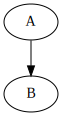

In [38]:
make_graph(['AB'])

### Causal graph

* A directed graph where each node represents a variable, and each arrow depicts a relationship between two variables. 
* Represents our __expert belief__ about the data generating process, with our assumptions encoded in missing connections (arrows) between variables (nodes). 
* Defining a causal graph is the first and the most critical step when following the Pearl's framework of causal inference.

### D-separation (Pearl, 1988)

* A criterion to identify __conditional independence__ between two variables: $ X \perp\!\!\!\perp Y \mid S $.
* $X$ and $Y$ are d-separated whenever all possible paths from $X$ to $Y$ are __blocked__ _(see next slide)_.
* We should test causal assumptions: if $X$ and $Y$ are d-separated, they should be uncorrelated.


* (Definition.) A path from $X$ to $Y$ is said to be blocked if either (i) it contains at least one arrow-emitting node that is in $S$, or (ii) it contains at least one collision node that is outside $S$ and has no descendant in $S$.

d = directional
d-connected is the opposite

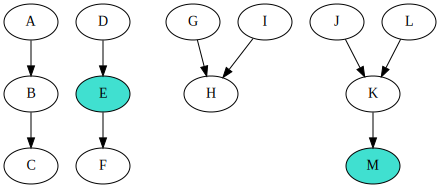

In [40]:
make_graph(**graph1)

* The path from $A$ to $C$ is __unblocked__, and $C$ can be reached from $A$
* Intuition: an intervention in A can have a causal effect on C


* The path from $D$ to $F$ is __blocked by conditioning__ on $E$
* $\Rightarrow D \perp\!\!\!\perp F \mid S=\{E\}$
* Intution: whatever happens in $D$, it can't have causal effect on $F$ because value of $E$ is fixed, and there is no other path from $D$ to $F$

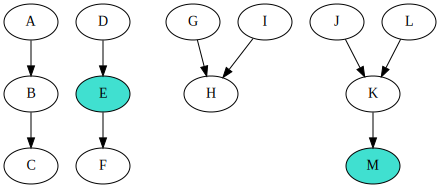

In [39]:
make_graph(**graph1)

* The path from $G$ to $I$ is __blocked by the colliding__ on $H$
* $\Rightarrow G \perp\!\!\!\perp I \mid S=\{\varnothing\}$
* Intuition: interventions in $G$ can't affect $I$ because the node $H$ is a "dead end" on the effect transmission path


* The path from $I$ to $L$ is __unblocked__ because the collision node $K$ has a conditioned descendant (child) $M$
* $\Rightarrow D \not\!\perp\!\!\!\perp F \mid S=\{M\}$
* Intuition: different to the previous graph, the collision node "leaks" information into the conditioning set $S$. The path would be blocked for $S=\{\varnothing\}$

### Back to the marketing application:

In [29]:
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
U -> different_room_assigned; U -> lead_time; U -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
}"""

model = dowhy.CausalModel(
    data=dataset,
    graph=causal_graph.replace("\n", " "),
    treatment='different_room_assigned',
    outcome='is_canceled')

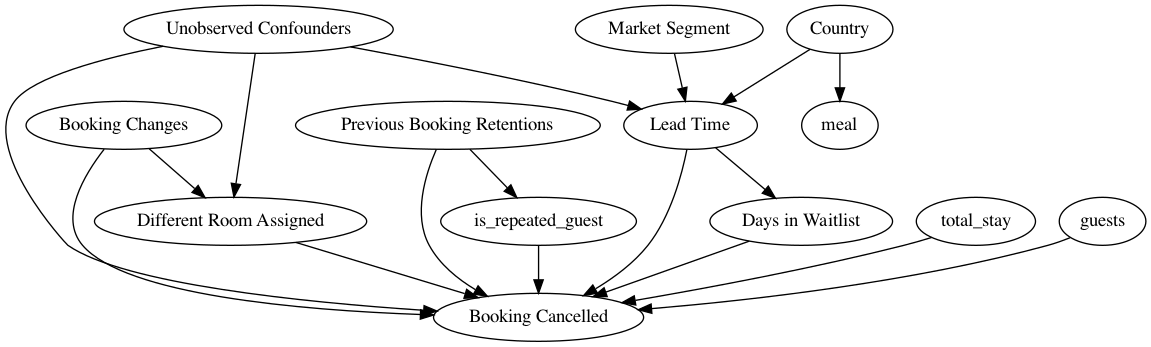

In [30]:
model.view_model()
display(Image(filename="causal_model.png"))

## (3) Identification

(3) __Identifying__ the estimand by checking whether explicit assumptions allow to solve for the parameter(s) of interest as function(s) of exogeneous variables

### Methods for covariate selection:
* back-door criterion
* front-door criterion
* instrumental variables
* mediation techniques

### Identifiability (skipped in presentation)

Can the controlled (post-intervention) distribution, $P(Y=y|do(x))$ be estimated from data governed by pre-intervention distribution, $P(z,x,y)$?

* According to Pearl's (2010, 12) definition, __a causal effect $ß$ is identifiable__ if its estimation depends solely on the distribution of observed variables and not on the model used for the estimation (for any model that satisfies assumptions encoded in the causal graph)\
_Main takeaway: The model does not matter as long as assumptions are satisfied!_

* It can be shown that $E(Y|do(x_0) = E(Y|X=x_0) = E(Y|f_Y(Z, x_0))$, where $f_Y$ is a model explaining $Y$, and $Z$ is a set of covariates d-connected with $Y$

* In particular, causal effects are __identifiable__ if the causal graph satisfies the requirements of the __Markovian model__: (i) it is _acyclic_ (no directed cycles) and (ii) all error terms are jointly independent.

* Any distribution generated by a Markovian model can be factorized as\
$P(v_1, \ldots, v_n) = \prod_iP(v_i|pa_i)$, and\
any distribution generated by a Markovian model with an intervention $do(X=x_0)$ can be given by truncated factorization\
$P(v_1, \ldots, v_n|do(x_0)) = \prod_{i|V_i \notin X}P(v_i|pa_i)|_{x=x_0}$.

* One can therefore easily compute the post-intervention distribution; see example below.

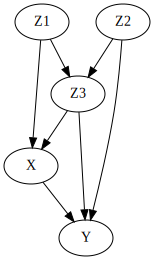

In [19]:
make_graph(**graph2) # adjusted from Pearl (2010, 15)

# Z1, Z2, Z3 are confounders
# X is the intervention variable
# Y is the target

For the causal graph above,

* the joint pre-intervention distribution is given by\
$P(x, z_1, z_2, z_3, y) = P(z_1)P(z_2)P(z_3|z_1,z_2)P(x|z_1,z_3)P(y|z_2,z_3,x)$

* the joint post-intervention distribution is given by\
$P(z_1, z_2, z_3, y|do(x_0)) = P(z_1)P(z_2)P(z_3|z_1,z_2)P(y|z_2,z_3,x_0)$

* and the causal effect can be obtained by marginalizing over Z variables\
$P(y|do(x_0)) = \sum_{z_1,z_2,z_3}P(z_1)P(z_2)P(z_3|z_1,z_2)P(y|z_2,z_3,x_0)$

* or, should a confounder (e.g., $Z_2$) be unmeasurable, simply by\
$P(y|do(x_0)) = \sum_{z_1,z_3}P(z_1)P(z_3|z_1)P(y|z_1,z_3,x_0)$

### Back-door criterion

* Isolate (by conditioning) all paths through which the data-generating process can influence the outcome $Y$ through a backward path from $X$
* For a causal path $X\!\longrightarrow\!Y$: we must go backwards from $Y$ to $X$


* (Definition.) Find a set of nodes 𝑆 that is "sufficient for adjustment" s.t. <br>
(i) no element of 𝑆 is a descendant (child) of 𝑋, and <br>
(ii) elements of 𝑆 block all back-door paths from 𝑋 to 𝑌

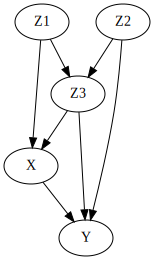

In [42]:
make_graph(**graph2) # adjusted from Pearl (2010, 15) 

# Z1, Z2, Z3 are confounders
# X is the intervention variable
# Y is the target

* What would be a sufficient set for the causal graph shown above? 
* Clearly, $Z_3$ blocks the back-door path $X\!\longleftarrow\!Z_3\!\longrightarrow\!Y$ (we walk backwards from $X$ to $Z_3$ and then forwards to $Y$)

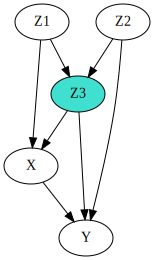

In [44]:
make_graph(**graph2, highlight=['O'])

* Now that $Z_3$ is in the conditioning set, another back-door "opens" (by conditioning on the collision node):  $X\!\longleftarrow\!Z_1\!\longrightarrow\!Z_3\!\longleftarrow\!Z_2\!\longrightarrow\!Y$
* We can "close" it by conditioning on $Z_1$ (or $Z_3$)

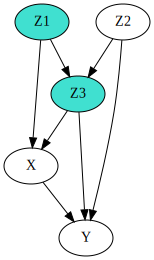

In [45]:
make_graph(**graph2, highlight=['O', 'A'])

Finally, holding $S = \{Z_1, Z_3\}$ constant, we can estimate the "true" causal effect of $X$ on $Y$.

More formally, the causal effect expression can be rewritten as $P(Y|do(X)) = \sum_{S} P(Y|X=x, S=s)P(S=s)$, where $S$ denotes the conditioning set.

The identification of a sufficient set to condition on is what happens in the `model.identify_effect()` step of the doWhy-pipeline.

### Back to the marketing application:

A total of 257 estimands identified for this model. 
First back-door estimand:

> Unconfoundedness assumptions:
If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,lead_time,U) = P(is_canceled|different_room_assigned,booking_changes,lead_time)

> Estimand:



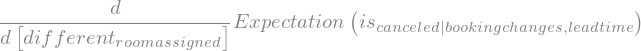

In [92]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
pretty_estimand_output(identified_estimand)

# https://github.com/microsoft/dowhy/issues/198#issuecomment-735269793
# 1 back-door estimand in dowhy==0.4; 257 in dowhy==0.5

## (4) Estimation

### Statistical estimation

* __Treatment assignment__: Propensity-based Stratification, Propensity Score Matching, Inverse Propensity Weighting
* __Outcome model__: Linear Regression, Generalized Linear Models
* __Instrumental variable equation__: Binary Instrument/Wald Estimator, Two-stage least squares, Regression discontinuity
* For front-door criterion and general mediation: Two-stage linear regression

### Target effect

* ATE: Average Treatment Effect
* ATT: ATE on Treated: those who were assigned a different room
* ATC: ATE on Control: those who were not assigned a different room


* ATE = P(customer cancels if a different room assigned) – P(customer cancels if no different room assigned)
* ATE = observable effect – counterfactual effect
* If bias=0, then ATE = observable effect

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units="ate")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: is_canceled~different_room_assigned+meal+booking_changes+total_stay+days_in_waiting_list+guests+lead_time+previous_bookings_not_canceled+country+market_segment+is_repeated_guest
Target units: ate

## Estimate
Mean value: -0.3346064358628692



Interpretation: On average, hotel bookings are 33.5% less likely to be canceled if a guest has been assigned a different room when chosen during the original booking.

### How is this possible? 
* 1) wrong assumptions encoded in the graph
* 2) counterfactual > observable effect
* 3) hotels discriminate against customers less likely to cancel their trip (e.g. business travelers)
* 4) real-world data

## (5) Robustness checks

### Robustness checks / Model refutation: 

- __Add Random Common Cause__: adding randomly drawn and independent covariates as common causes into the data and running the analysis. As a result, the estimate shouldn't change. If it changes, the check failed.
- __Placebo Treatment__: randomly assignsing any independent covariate as a treatment, which replaces the true treatment variable and running the analysis. The estimate causal effect should go to 0. This would mean, that our assumptions are correct.
- __Dummy Outcome__: replacing the true outcome variable with an independent random variable. 
The estimated caual effect should go to 0. This would again mean, that our assumptions are correct.
- __Add Unobserved Common Causes__: adding an additional confounder to the dataset that is correlated with the treatment and the outcome. The sensitivity of the estimate should be low. If its high, the check has failed.
- __Data Subsets Validation__: replacing the dataset with a randomly created subset. The estimated effect shouldn't change or vary significantly within the procedure of replacing the subsets with each other. If there is low variation and no significant change, the assumptions are correct. 
- __Bootstrap Validation__: replacing the given dataset with bootstrapped samples from the same dataset. The estimated effect shouldn't change significantly.

(Sharma and Kiciman, 2020, Dixit, 2020)

In [18]:
refuter = CausalRefuter(**refutation_config)
refuter.refute(model, identified_estimand, estimate)

random_common_cause: Effect should not change significantly -- PASSED with tolerance of +/- 0.1
effect: -0.34 -> -0.34

placebo_treatment_refuter: Effect should go to zero -- PASSED with tolerance of +/- 0.1
effect: -0.34 -> 0.00

dummy_outcome_refuter: Effect should go to zero -- PASSED with tolerance of +/- 0.1
effect: -0.34 -> 0.00

data_subset_refuter: Effect should not change significantly -- PASSED with tolerance of +/- 0.1
effect: -0.34 -> -0.34

bootstrap_refuter: Effect should not change significantly -- PASSED with tolerance of +/- 0.1
effect: -0.34 -> -0.34



The effects change exactly as expected compared to the original model; this is often not the case. It is up to the analyst to decide what deviance from the expected effect change is to be expected.

## Conclusions

### Pearl's criticism in one sentence

- "_Causal conclusions are only as valid as the causal assumptions upon which they rest._" (Pearl, 2010)
- ⠀+ implicit covariate selection

### Pearl's contribution in one sentence

- Graphical models assist the researcher in specifying the (non-)experimental setup, clearly formulating the research question and structuring the research process

### Key message

- Pearl's graphical theory of causality should be your go-to gateway to addressing causal claims

### Then why is Pearl's framework so unknown/unpopular?

- Difficulty for/reluctance of "traditionally" trained statistician to leave their parametric/functional world of probability calculus
- Unawareness of structural equations modelling
- Missing discipline to clearly formulate experiential knowledge as causal assumptions in a scientic notation
- Notation

### Outlook: _Causal inference beyond the potential outcome framework_

- A very broad topic with a lot of underlying theory


- Cross-sectional causal inference $\neq$ dynamic causality (time series, stationarity!)
- Dynamic causality: causal inference & treatment ~ impulse response functions from e.g. SVAR models
- Classical research questions from macroeconomics, e.g. causal effects of monetary policy on GDP, consumption etc. (Romer-Romer shocks, 2004)

# 2nd example: True causal effect in a linear model

To give a first example, let's compare the standard approach of a linear regression (where we already impose a functional form - linearity and additivity - !) with one starting with a graphical representation that translates into the familiar linear regression specification.

In [6]:
def standardize(data, ddof=1):
    """standardizes a matrx using `ddof` = 1 for an unbiased estimator of the sample variance"""
    return (data - np.mean(data))/np.std(data, ddof=ddof)

x = standardize(np.array([2, 4, 0])) # no intercept
y = standardize(np.array([4, 6, 1]))

df = pd.DataFrame({
    'hours_studied': x,
    'points_achieved': y
})

df

,hours_studied,points_achieved
0,0.0,0.132453
1,1.0,0.927173
2,-1.0,-1.059626


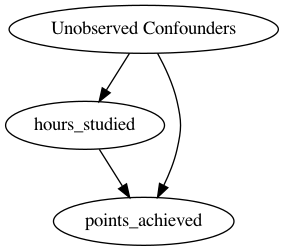

In [7]:
# Step 1: Define & assume — encoding assumptions in a causal graph

causal_graph = """digraph {
hours_studied;
points_achieved;
U[label="Unobserved Confounders"]; 
hours_studied -> points_achieved;
U->hours_studied; U->points_achieved;
}"""

model = dowhy.CausalModel(
    data=df,
    graph=causal_graph.replace("\n", " "),
    treatment="hours_studied",
    outcome="points_achieved"
)

model.view_model()
from IPython.display import Image, display
display(Image(filename='causal_model.png'))

From the graphical model the implicit structural representation reads

$ f_{X}(u_{X}) = X = u_X \\
f_{Y}(X, u_Y) = Y = \beta X + u_Y$

Note that without the graph the directionality is ambiguous (e.g. rearrange X in terms of Y)! To overcome this notational shortcoming IV estimation has been proposed that injects directionality through exclusion assumptions and is e.g.operationalised through 2SLS which uncorrelates the error terms through the endogeneous variable.

In [8]:
# Step 2: Identify

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
       d                                      
────────────────(Expectation(points_achieved))
d[hours_studied]                              
Estimand assumption 1, Unconfoundedness: If U→{hours_studied} and U→points_achieved then P(points_achieved|hours_studied,,U) = P(points_achieved|hours_studied,)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Note that $Cov(X,Y) = \beta$ (since $Cov(X, u_Y) = Cov(u_X, u_Y) = 0$).
The latter condition is an optimality condition (by construction) that comes from the FONC of the minimized least-squares criterion and gives you k equations for k unknown parameters - identifyability guaranteed (and no dependence of $\beta$ on the error term $u_Y$ but of **$X$ and $y$ only**). Pearl complains that this condition has been routinely used, "often thoughtlessly, to justify the estimation of structural coefficients by regression techniques" (Pearl, 2010). The key point is that this **optimality condition shouldn't be justified by an optimization problem** (which is only needed for quantification) but **by an underlying model to define the axioms used.** Moreover, the effect coefficient $\beta$ is not only interpreted as causal but it's **proven** to be from the structural equations. Thus, note that background factors in structural equations differ fundamentally from residual terms in regression equations in their interpretation and construction. However, actual actual **ability of estimation** may be impeded by correlatedness of error terms.
Endogeneity (OVB, attentuation bias, simultaneity bias e.g. demand<-->supply) leads to biased estimates and inconsistency, violating standard (asymptotic) inference.

In [9]:
# Step 3: Estimate

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: points_achieved~hours_studied
Target units: ate

## Estimate
Mean value: 0.9933992677987824
p-value: [0.0731864]



/Users/gleb/CODING/informationsystems-causalinference-pearl/venv-IS/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [10]:
# Step 4: Refute

refuter = CausalRefuter(**refutation_config)
refuter.refute(model, identified_estimand, estimate) 

# more on refutation in the following chapter
# some tests failed due to a very small size of the dataset

random_common_cause: Effect should not change significantly -- PASSED with tolerance of +/- 0.1
effect: 0.99 -> 1.09

placebo_treatment_refuter: Effect should go to zero -- PASSED with tolerance of +/- 0.1
effect: 0.99 -> 0.00

dummy_outcome_refuter: Effect should go to zero -- FAILED with tolerance of +/- 0.1
effect: 0.99 -> -0.20

data_subset_refuter: Effect should not change significantly -- PASSED with tolerance of +/- 0.1
effect: 0.99 -> 0.97

bootstrap_refuter: Effect should not change significantly -- FAILED with tolerance of +/- 0.1
effect: 0.99 -> 0.76



In [11]:
np.cov(x, y)

array([[1.        , 0.99339927],
       [0.99339927, 1.        ]])

In [12]:
# Manual OLS

X = x.reshape((3,1)) # transforming a flat array to a matrix

XtX = np.matmul(X.transpose(), X)
Xty = np.matmul(X.transpose(), y)

OLS = np.matmul(
    np.linalg.inv(XtX), 
    Xty
)

OLS

array([0.99339927])

In [13]:
x_std = np.std(np.array([2, 4, 0]), ddof=1)
y_std = np.std(np.array([4, 6, 1]), ddof=1)
print(x_std, y_std)

2.0 2.5166114784235836


In this example, a 1 standard-unit increase in hours studied in terms of hours studied increases, on average (but don't have to, linear regression simply computes the expectation function), the points achieved by one standard-unit in terms of hours studied times the beta coefficient. In this case, if you additionally studied 2 hours, on average the points achieved would increase by 1 * 0.99 = 0.99 standard-units which amounts to 3.67 points. (Moreover, in the absence of multicollinearity the feature hours_studied explains about (0.99)**2 * 100 = 98.68 percent of the variance in the points_achieved.)

Both the OLS and the causal model lead to the same result for this simple example.

# Bibliography

- Angrist, J., G. Imbens, and D. Rubin (1996): “Identification of causal effects using
instrumental variables (with comments),” Journal of the American Statistical
Association, 91, 444–472.
- Dixit, S. (2020) Beyond Predictive Models: The Causal Story Behind Hotel Booking Cancellations. Retrieved on 09.12.2020 https://towardsdatascience.com/beyond-predictive-models-the-causal-story-behind-hotel-booking-cancellations-d29e8558cbaf
- Neyman, J. (1923): “On the application of probability theory to agricultural experiments.
Essay on principles. Section 9,” Statistical Science, 5, 465–480.
- Pearl, J. (2018) The Seven Tools of Causal Inference with Reflections on Machine Learning. https://ftp.cs.ucla.edu/pub/stat_ser/r481.pdf
- Pearl, J. (2010) An Introduction to Causal Inference https://ftp.cs.ucla.edu/pub/stat_ser/r354-corrected-reprint.pdf
- Pearl, J. (2000) Causality: Models, Reasoning, and Inference. Chapter 1 http://bayes.cs.ucla.edu/BOOK-2K/
- Rosenbaum, P. and D. Rubin (1983): “The central role of propensity score in observational
studies for causal effects,” Biometrika, 70, 41–55.
- Rubin, D. (1974): “Estimating causal effects of treatments in randomized and nonrandomized
studies,” Journal of Educational Psychology, 66, 688–701.
- Sharma, A. and Kiciman, E. (2020) DoWhy: An End-to-End Library for Causal Inference. https://arxiv.org/abs/2011.04216
- Qingyuan Zhao & Trevor Hastie (2019) Causal Interpretations of Black-Box Models, Journal of Business & Economic Statistics, DOI: 10.1080/07350015.2019.1624293